In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from pathlib import Path
from datetime import datetime
import urllib3
# from numba import jit

import yfinance as yahooFinance
import investpy

import kit as kit

In [3]:
# pd.set_option('display.max_rows', 500)
# pd.reset_option('display.max_rows')

pd.options.mode.chained_assignment = None  # default='warn'
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#### Function definition

In [4]:
def get_asset_yahoo(asset):
  
    ind = yahooFinance.Ticker(asset).history(period="max")
    ind = ind["Close"]
    ind.name = asset.split('.', 1)[0]
    
    return ind

def get_asset_investing(asset, asset_name, date_beg='01/01/2009'):
    
    search = investpy.search_quotes(text=asset, n_results=1)
    ind = search.retrieve_historical_data(from_date=date_beg, to_date=datetime.today().strftime('%d/%m/%Y'))["Close"]
    ind.name = asset_name
    
    return ind

def get_asset_local(asset):

    ind = pd.read_csv(asset, sep=";", decimal=',').set_index('Date')
    ind.index = pd.to_datetime(ind.index, format="%d/%m/%Y")
    
    return ind

def get_asset(list_yahoo=None, list_investing=None, list_local=None):
    
    if list_yahoo == None:       
        prices_yahoo = None  
    else:    
        prices_yahoo = pd.concat((get_asset_yahoo(f) for f in list_yahoo), axis=1)
        
    if list_investing == None:      
        prices_investing = None      
    else:     
        prices_investing = pd.concat((get_asset_investing(*f) for f in list_investing), axis=1)
        
    if list_local == None:        
        prices_local = None      
    else:    
        prices_local = pd.concat((get_asset_local(f) for f in list_local), axis=1)
    
    prices = pd.concat([prices_yahoo, prices_investing, prices_local], axis=1)  
    
    return prices

In [5]:
def frame_returns(prices):
    
    df = prices.pct_change()
    
    return df

In [6]:
def create_trades():
    
    trades = pd.DataFrame(columns=["Date", "Ticker", "Amount"])
    
    return trades

def join_trades(df, trades):
    
    trades["Date"] = pd.to_datetime(trades["Date"], format="%d-%m-%Y")
    trades = trades.set_index(["Ticker","Date"]).rename(columns={'Amount':'Trades'})
    
    df_stack = df.stack().reset_index().rename(columns={'level_1':'Ticker', 0: 'Returns'}).set_index(["Ticker", "Date"])
    
    df_join = df_stack.join(trades).unstack(level=0)
    df_join.loc[:,"Trades"].fillna(0, inplace = True)
    
    return df_join

In [7]:
# @jit(nopython=True)
def roll(a,b):
    res = np.empty(b.shape)
    res[0] = b[0]
    for i in range(1, res.shape[0]):
        res[i] = res[i-1] * (1 + a[i]) + b[i]
    return res

def compute_wealth(df):
    
    df_wealth = df

    for i in df_wealth["Trades"].columns:

        df_wealth[("Total", i)] = roll(*np.nan_to_num(df_wealth[[("Returns", i), ("Trades", i)]].values.T))
        
    return df_wealth

In [8]:
def portfolio_rets_weights(df):
    
    weights = df["Total"].div(df["Total"].sum(axis=1), axis=0)  
    
    r = df["Returns"]  
    
    r['PORT'] =  (weights * r).sum(axis=1) 
    
    return r, weights

In [9]:
def rolling_vol(r, time_period = 90, col_drop_plot = None):
    
    roll_vol = r.drop(columns = col_drop_plot).rolling(time_period, min_periods = int(time_period*0.2)).apply(kit.annualize_vol)
    
    roll_vol.plot(figsize=(16,5), title = '{}-periods rolling volatility'.format(time_period))
    
    return roll_vol

def portfolio_report(df, weights = None, date_beg = None, date_end = None, col_drop_plot = None, time_period = 90):
    
    if date_end == None:
        
        date_end = df.index[-1]
        
    if col_drop_plot == None:
    
        (1+df.dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
        
        df.dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown
    
    else:
        
        (1+df.drop(columns = col_drop_plot).dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
        
        df.drop(columns = col_drop_plot).dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown
        
    stats = kit.summary_stats(df.dropna()[date_beg:date_end], riskfree_rate=0)
    
#     roll_vol = rolling_vol(df.dropna()[date_beg:date_end], time_period = time_period, col_drop_plot = col_drop_plot)
    
    if weights is not None:
    
        weights.dropna().plot(figsize=(16,5), title = 'Portfolio weights')
    
    return stats

#### Parameters initialization

In [10]:
# Yahoo: Introduce ticker as in Yahoo Finance (.DE stands for XETRA)
list_yahoo = ["EUNL.DE", "XDEM.F", "4GLD.DE", "WCOA.MI", "ZPRS.DE", "EUNZ.F", "BTC-EUR"]

# Investing: First element is Investing text search, second is desired name for the asset
list_investing = [['Fundsmith Equity T Acc EUR', 'FSMI'], ['MFS Meridian Prudent Wealth I1 EUR', 'PRUD']]

# Local: Write your own path. csv must contain only two columns, 'Date' with date format "%d/%m/%Y" and 'asset name' (e.g FSMI) with asset prices
list_local = glob.glob(r'C:\Users\aguil\OneDrive\Escritorio\Escritorio\Python Projects\6. Investing projects\data\Assets' + "/*.csv")

#### Execution

Wall time: 9.32 s


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.003502,0.125606,-0.476386,4.541469,0.013761,0.019982,0.027883,-0.091344
BTC-EUR,0.475878,0.794475,0.124595,4.635473,0.063421,0.088797,0.598984,-0.523755
EUNL,0.335522,0.128484,-0.292477,5.308725,0.012324,0.018474,2.611392,-0.046791
EUNZ,0.111325,0.114071,-0.412220,4.555781,0.011970,0.015996,0.975928,-0.054096
FSMI,0.300609,0.110987,0.085942,3.267308,0.010263,0.013588,2.708508,-0.055303
PRUD,0.133252,0.062670,-0.341357,4.296848,0.006322,0.009217,2.126242,-0.024941
WCOA,0.362801,0.138893,-1.324770,8.423433,0.015098,0.022438,2.612097,-0.080140
XDEM,0.232561,0.178213,-0.493889,3.861338,0.018797,0.026955,1.304961,-0.121515
ZPRS,0.261312,0.165244,-0.294355,5.125396,0.016493,0.022767,1.581370,-0.091736


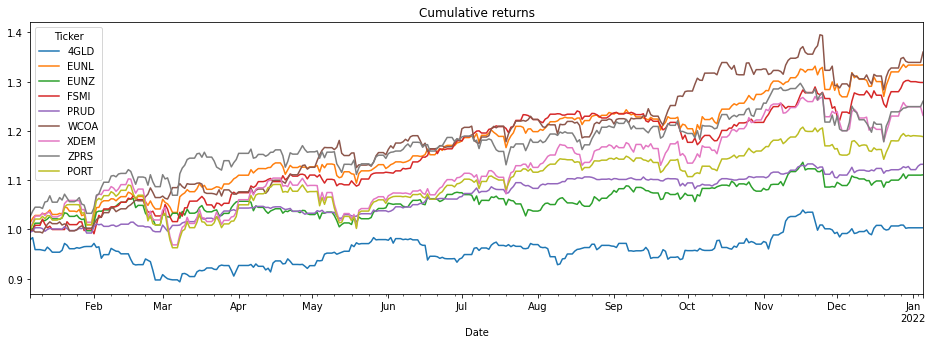

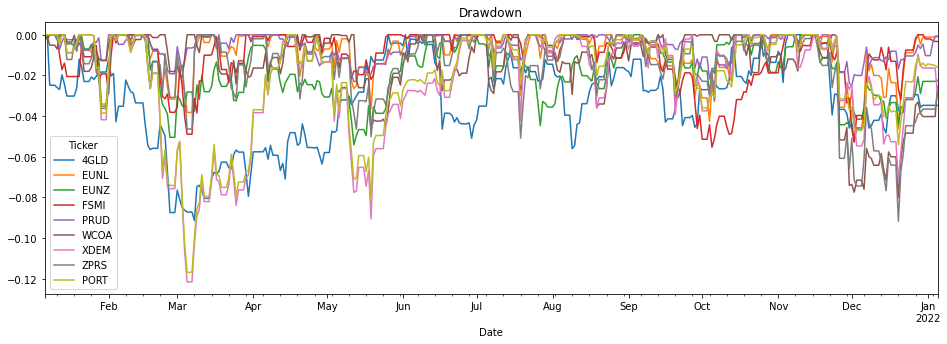

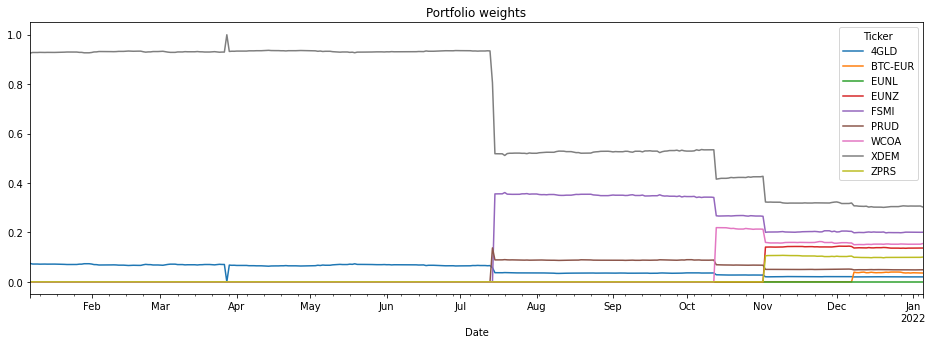

In [11]:
%%time

prices = get_asset(list_yahoo, list_investing, list_local=None)

rets = frame_returns(prices)

trades = create_trades()

trades = trades.append({"Date": "07-01-2021","Ticker":"4GLD", "Amount":300.88}, ignore_index=True)
trades = trades.append({"Date": "07-01-2021","Ticker":"XDEM", "Amount":3728.27}, ignore_index=True)
trades = trades.append({"Date": "28-03-2021","Ticker":"4GLD", "Amount":-282.40}, ignore_index=True)
trades = trades.append({"Date": "29-03-2021","Ticker":"4GLD", "Amount":273.24}, ignore_index=True)
trades = trades.append({"Date": "14-07-2021","Ticker":"PRUD", "Amount":700.00}, ignore_index=True)
trades = trades.append({"Date": "15-07-2021","Ticker":"FSMI", "Amount":2800.00}, ignore_index=True)
trades = trades.append({"Date": "13-10-2021","Ticker":"WCOA", "Amount":2240.10}, ignore_index=True)
trades = trades.append({"Date": "02-11-2021","Ticker":"ZPRS", "Amount":1494.57}, ignore_index=True)
trades = trades.append({"Date": "02-11-2021","Ticker":"EUNZ", "Amount":1991.72}, ignore_index=True)
trades = trades.append({"Date": "08-12-2021","Ticker":"BTC-EUR", "Amount":584.46}, ignore_index=True)

rets_trades = join_trades(rets, trades)

rets_trades_wealth = compute_wealth(rets_trades)

rets_portfolio, weights_portfolio = portfolio_rets_weights(rets_trades_wealth)

portfolio_report(rets_portfolio, weights = weights_portfolio, date_beg = "2021-01-06", col_drop_plot = ["BTC-EUR"])

# roll_vol = rolling_vol(rets_portfolio.dropna()["2021-01-06":], time_period = 90, col_drop_plot = ["BTC-EUR"])

# Other analysis

#### Test current weights on a longer period

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.101528,0.127844,-0.062768,9.479325,0.012080,0.019121,0.794160,-0.182267
BTC-EUR,0.463794,0.785969,-0.098149,10.508301,0.060616,0.093193,0.590091,-0.827479
EUNL,0.149947,0.174377,-0.992311,15.160397,0.017670,0.028042,0.859906,-0.336322
EUNZ,0.055970,0.153009,-0.981799,9.781571,0.016943,0.024308,0.365793,-0.267947
FSMI,0.172758,0.152178,-0.788388,8.896633,0.016215,0.024234,1.135243,-0.269354
PRUD,0.102880,0.072981,-0.070758,4.884694,0.007228,0.010234,1.409681,-0.073030
WCOA,0.075058,0.115927,-0.644119,8.475449,0.012706,0.018106,0.647462,-0.218176
XDEM,0.173325,0.197730,-0.413499,7.912027,0.020032,0.031282,0.876574,-0.317425
ZPRS,0.115341,0.193366,-0.688672,11.980933,0.019662,0.030138,0.596488,-0.402168


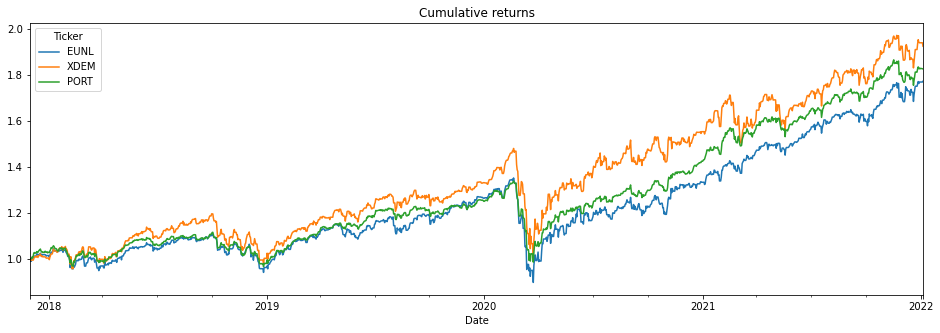

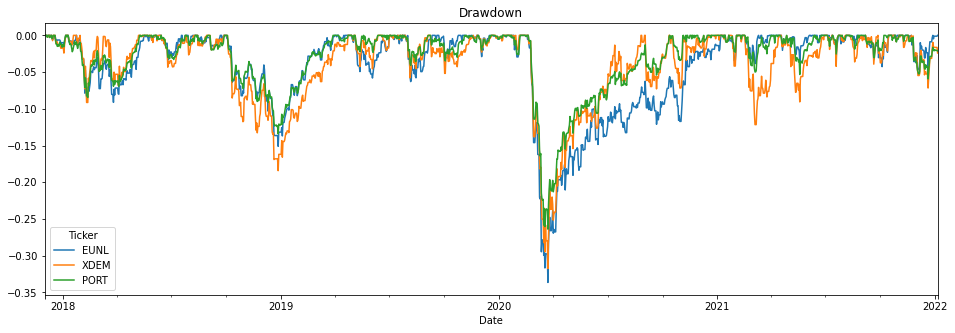

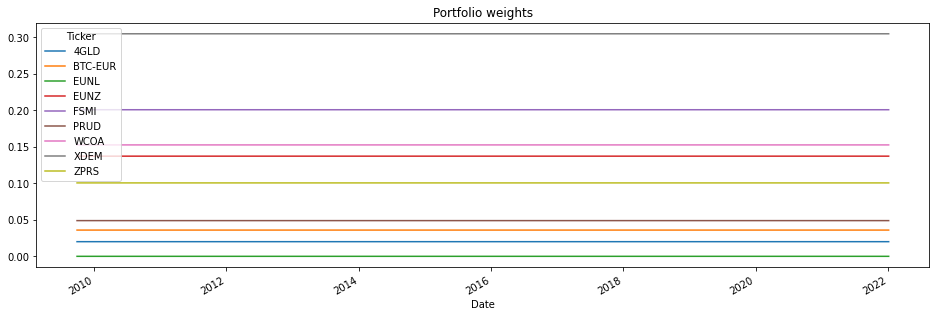

In [16]:
weights = weights_portfolio.copy()
weights.iloc[:-1,:]=np.nan
weights=weights.fillna(method="bfill")

df_portfolio = rets_trades_wealth["Returns"]  
df_portfolio['PORT'] = (weights * df_portfolio).sum(axis=1) 

col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI"]

portfolio_report(df_portfolio, date_beg = "2017-12", weights = weights, col_drop_plot = col_drop_plot)
# roll_vol = rolling_vol(df_portfolio.dropna()["2017-12":], col_drop_plot = col_drop_plot)

#### Monthly/weekly/business days report

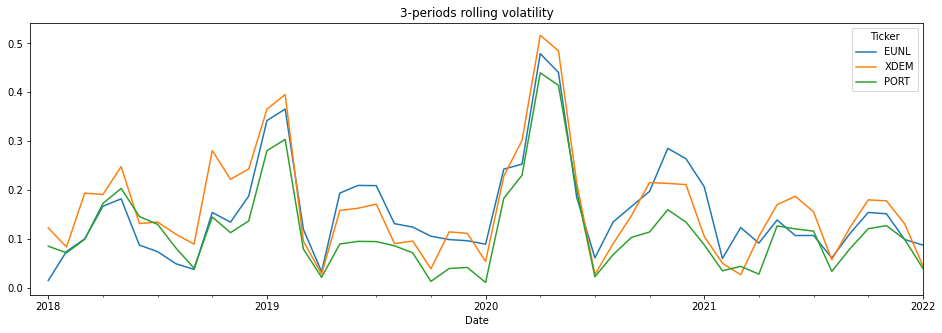

In [21]:
# df_portfolio_w = df_portfolio.resample('W').apply(kit.compound)
df_portfolio_m = df_portfolio.resample('M').apply(kit.compound)
# df_portfolio_b = df_portfolio.resample('B').apply(kit.compound)

# portfolio_report(df_portfolio_w, date_beg = "2017-12", weights = weights, col_drop_plot = col_drop_plot)


roll_vol = rolling_vol(df_portfolio_m.dropna()["2017-12":], time_period = 3, col_drop_plot = col_drop_plot)

#### Plot density function of returns

(-0.04, 0.04)

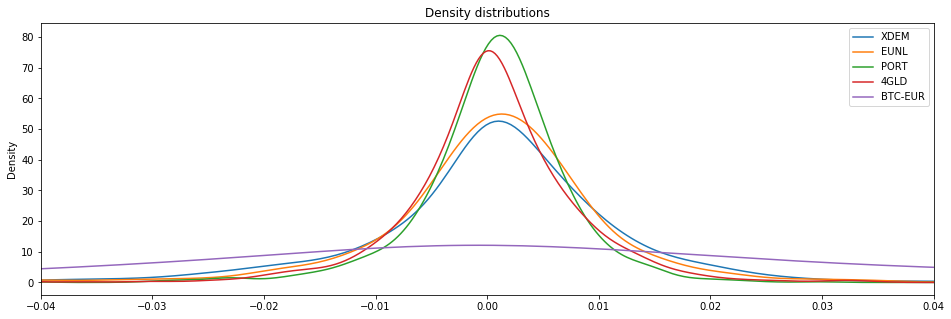

In [60]:
r = df_portfolio_b.loc["2017-12":, ["XDEM", "EUNL", "PORT", "4GLD", "BTC-EUR"]]
x_lim = 0.04

# r.hist(bins=30, figsize=(15,10), label='x')

r.plot.kde(figsize=(16,5), title = 'Density distributions')
plt.xlim([-x_lim, +x_lim])

#### Get rolling correlation of rest of assets against a particular asset

,4GLD,BTC-EUR,WCOA,PRUD,EUNZ,FSMI,XDEM,PORT,ZPRS,EUNL
0,-0.018522,0.175583,0.450048,0.684403,0.686326,0.715056,0.76495,0.882312,0.903893,1.0


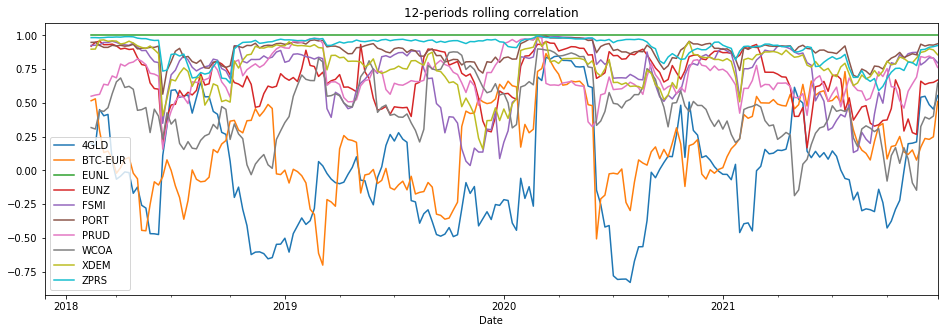

In [61]:
def rolling_corr(r, time_period = 90, col= 'XDEM'):
    
    corr = r.rolling(time_period).corr()[col].unstack(level = 1)
    
    corr.plot(figsize=(16,5), title = '{}-periods rolling correlation'.format(time_period))
    
    return pd.DataFrame(corr.mean().sort_values(ascending = True)).T

r = df_portfolio_w.loc["2017-12":]

# Note: Daily data and data quality issues in funds could give unaccurate results (better with long monthly periods)
rolling_corr(r, time_period = 12, col = 'EUNL')

#### Study inclusion of alternative asset in the portfolio

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0.0,0.153690,0.125363,-1.230592,16.371812,0.010707,0.017223,1.225964,-0.263741
0.1,0.153898,0.126877,-1.209245,16.694254,0.010763,0.017624,1.212970,-0.265828
0.2,0.153776,0.130578,-1.130404,16.769864,0.010949,0.018182,1.177659,-0.267973
0.3,0.153326,0.136288,-1.007044,16.605404,0.011254,0.018967,1.125015,-0.270176
0.4,0.152547,0.143767,-0.858572,16.251219,0.011669,0.019989,1.061069,-0.272436
0.5,0.151441,0.152757,-0.703215,15.776679,0.012183,0.021098,0.991387,-0.274753
0.6,0.150010,0.163007,-0.553937,15.246876,0.012787,0.022269,0.920264,-0.277125
0.7,0.148254,0.174296,-0.417967,14.710614,0.013470,0.023578,0.850588,-0.279553
0.8,0.146175,0.186434,-0.298151,14.198660,0.014221,0.024954,0.784059,-0.282035
0.9,0.143775,0.199266,-0.194622,13.727226,0.015030,0.026434,0.721524,-0.284572


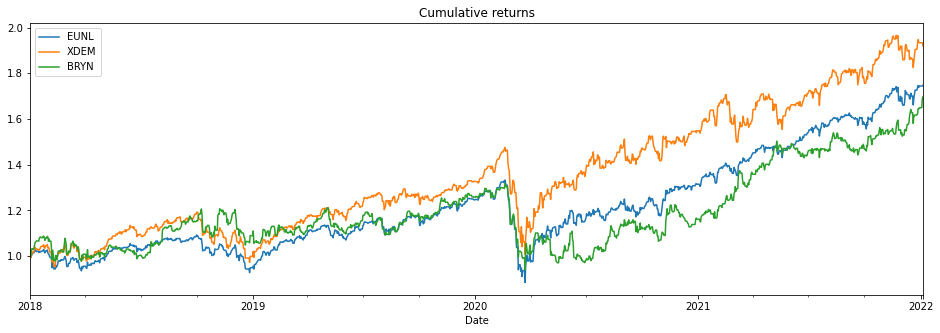

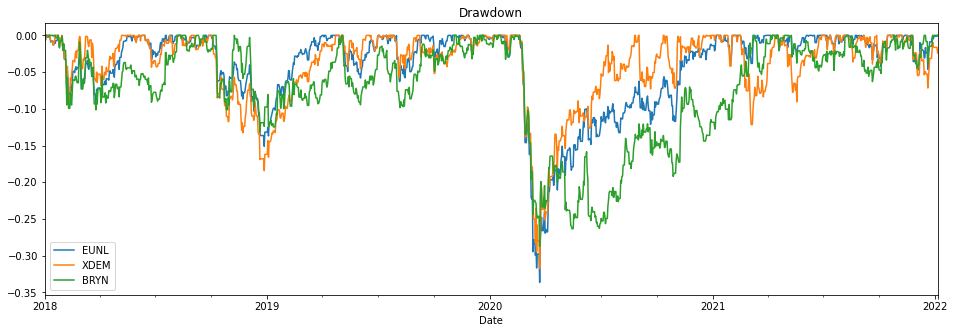

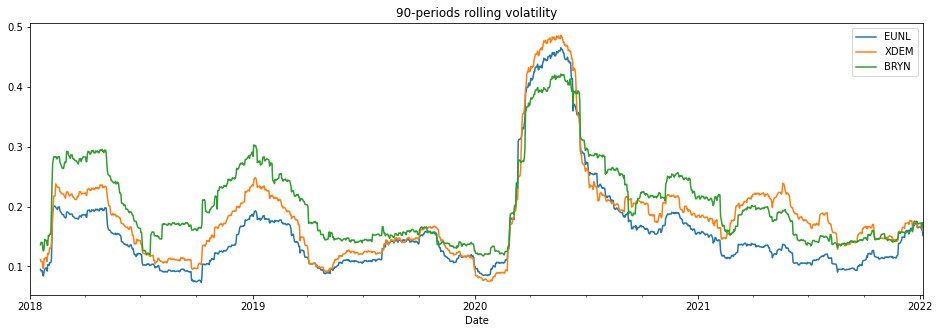

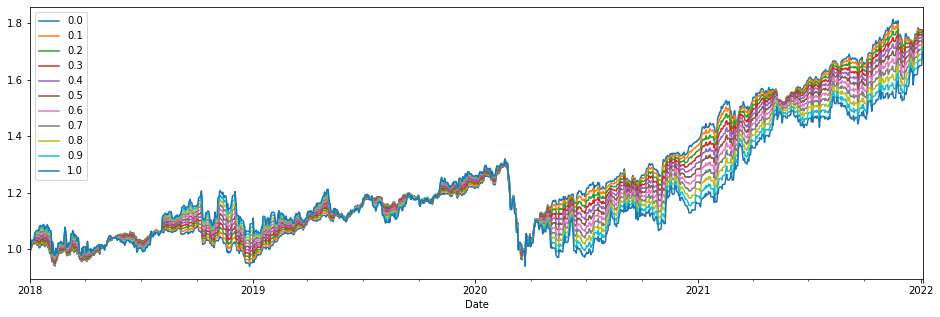

In [22]:
alt_name = 'BRYN'

# Get asset returns
alt_ticker = ['BRYN.DE']
alt_price = get_asset(list_yahoo = alt_ticker) 
alt_rets = alt_price.pct_change()["2009-09-28":]

# Append returns
r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
r.loc[:,alt_name] = r.loc[:,alt_name].fillna(0)
r = r.dropna()

# Optional: Include in portfolio report
col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI"]
portfolio_report(r, date_beg = "2018", col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(r["2018":], col_drop_plot = col_drop_plot)

# Optional: Get correlation matrix
# r['2018':].resample('M').apply(kit.compound).corr()

# Define a function that include given weight into portolio weights
def normalize(weight_series,  w):

    a = weight_series
    a = a*(1-w)
    a[alt_name] = w
    
    return a

# Define weights to backtest
weight_series = weights_portfolio.iloc[-1]
weights = np.array([normalize(weight_series,  w) for w in np.linspace(0,1,11)])

# Get results
results = (r @ weights.T)
results.columns = np.around(weights[:,-1],2).tolist()
(1+results["2018":]).cumprod().plot(figsize=(16,5))
kit.summary_stats(results["2018":], riskfree_rate = 0)